# Combining the plates together, producing filtering plots and filtering the cells, and Examining contamination


This notebook starts by combining plates together into one anndata object and saving that object as an unfiltered data file. This notebook is expected to run linearly from top to bottom. 

Import Statements

In [1]:
import numpy as np
import pandas as pd
import anndata as ad

import iqplot
import anndata
import scanpy as sc
import matplotlib.pyplot as plt # import matplotlib to visualize our qc metrics
import seaborn as sns
from scipy.io import mmread

import scanpy as sc
from scipy import io
import sys
import warnings
import matplotlib.pyplot as plt

import bokeh.io
bokeh.io.output_notebook()

#load in Filtering Script
%load_ext autoreload
%autoreload 1
%aimport Filtering_Script

Loading BokehJS ...

Loading BokehJS ...

# Combining metadata and anndata files

Read in the metadata and anndata object, and combine them together for each plate

In [107]:
for n in range(1,9):
    meta_path = "Meta_data/Meta_Data_Flow/Cal-JB-s00{}-Meta.csv".format(n) 
    anndata_path = "Kalisto_Allignments/Origonal_Files/s00{}_adata.h5ad".format(n)

    meta_data_df = pd.read_csv(meta_path,index_col='Sequence') #read in meta data
    
    vars()['plate' + str(n)] = anndata.read_h5ad(anndata_path) #read in anndata
    # Can be used to convert the column indices to be gene names rather than Ensembl gene IDs
    vars()['plate' + str(n)].var_names = list(vars()['plate' + str(n)].var.gene_name)
    vars()['plate' + str(n)].var_names_make_unique()

    #reorder the meta data df in the order of the observations
    #This makes sure that the two datafames will be alinged properly 
    meta_data_df.reindex(vars()['plate' + str(n)].obs.index.to_list()) 
    
    #merge meta data
    vars()['plate' + str(n)].obs = vars()['plate' + str(n)].obs.merge(meta_data_df,left_index=True, right_index=True, how='inner')

    #save the plate for downstream analysis as a new object
    vars()['plate' + str(n)].write('Kalisto_Allignments/Complete_Metadata_Files/plate{}_unfilt.h5ad'.format(n), compression="gzip")

## combine each plate together

Start by defining the date and final file name output

In [4]:
date = "_20240729"
full_file_name = 'Unfiltered_full_data' + date + '.h5ad'
location_full_file_name = "Data_Files/" + full_file_name

In [10]:
plate_array=[plate1,plate2,plate3,plate4,plate5,plate6,plate7,plate8]
All_plate_data = ad.concat(plate_array,axis = 0) #axis of 0 concatenates along 'obs'
All_plate_data.obs_names_make_unique() #dealing with the observation names not being unique
print(All_plate_data)

#save the full data for later and reload it as object named data
All_plate_data.write(location_full_file_name, compression="gzip")
data = anndata.read_h5ad(location_full_file_name)

C:\Users\cpuki\anaconda3\Lib\site-packages\anndata\_core\anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 3072 × 33580
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'Unnamed: 0', 'Plate ID', 'Row', 'Column', 'Genotype', 'Mouse', 'Region', 'Experiment Date', 'DOB', 'Cage', 'wellID', 'Row-Column', 'Number', 'FSC Height', 'FSC Area', 'FSC Width', 'SSC Height', 'SSC Area', 'SSC Width', '525/50 GFP Height', '525/50 GFP Area', '525/50 GFP Width', '665/30 Dye Cycle Ruby Height', '665/30 Dye Cycle Ruby Area', '665/30 Dye Cycle Ruby Width', 'Time', 'Well Index'


# Filtering

The filtering metrics were chosen to determine one set that is compatible with all the plates on a per plate basis. See the filtering script for functions that perform the filtering and produce graphs.

In [8]:
# reread in the data again--redundant but good to check
data = anndata.read_h5ad(location_full_file_name)
data

AnnData object with n_obs × n_vars = 3072 × 33580
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'Unnamed: 0', 'Plate ID', 'Row', 'Column', 'Genotype', 'Mouse', 'Region', 'Experiment Date', 'DOB', 'Cage', 'wellID', 'Row-Column', 'Number', 'FSC Height', 'FSC Area', 'FSC Width', 'SSC Height', 'SSC Area', 'SSC Width', '525/50 GFP Height', '525/50 GFP Area', '525/50 GFP Width', '665/30 Dye Cycle Ruby Height', '665/30 Dye Cycle Ruby Area', '665/30 Dye Cycle Ruby Width', 'Time', 'Well Index'

Preproccesing the data by quantifying the levels of types of reads.

In [10]:
#preprocessing
data.var['ERCC'] = data.var_names.str.startswith('ERCC-')
data.var['mt'] = data.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
data.var['ribosomal'] = data.var_names.str.startswith('rp')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(data, qc_vars = ['ERCC','mt','ribosomal'],inplace=True) #run QC and save it to the andata object


## Filtering metrics

And running the filtering script to produce a new column in the metadata for the filtered status of the cell.

In [11]:
#default filtering metrics:
n_Ercc = 400 #take cells with above this many ERCC counts
mt_pct = 10 #cut off for mitochondrial genes
n_UMI = 800 #cut off for number of UMIS
n_UMI_high = 30000
Ercc_pct = 70

#running filtering:
Filtering_Script.scanpy_filtering(data)

AnnData object with n_obs × n_vars = 3072 × 33580
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'Unnamed: 0', 'Plate ID', 'Row', 'Column', 'Genotype', 'Mouse', 'Region', 'Experiment Date', 'DOB', 'Cage', 'wellID', 'Row-Column', 'Number', 'FSC Height', 'FSC Area', 'FSC Width', 'SSC Height', 'SSC Area', 'SSC Width', '525/50 GFP Height', '525/50 GFP Area', '525/50 GFP Width', '665/30 Dye Cycle Ruby Height', '665/30 Dye Cycle Ruby Area', '665/30 Dye Cycle Ruby Width', 'Time', 'Well Index', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_ERCC', 'log1p_total_counts_ERCC', 'pct_counts_ERCC', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribosomal', 'log1p_total_counts_ribosomal', 'pct_counts_ribosomal', 'Filtered_Status'
    var: 'ERCC', 'mt', 'ribosomal', 'n_cells_by_counts', 'mean_coun

## Producing the full suite of Plots:

In [80]:
Filtering_Script.knee(data)
Filtering_Script.total_counts_plot(data)
Filtering_Script.pct_mt_plot(data)
Filtering_Script.total_ERCC_plot(data)
Filtering_Script.pct_ERCC_plot(data)  
Filtering_Script.knee_colored(data)

            cell_counts  Filtered_Status  Position
TCTTGCTG-3     180880.0            False       1.0
AAAGCGGA-3     146156.0            False       2.0
TAGACGCT-3     142563.0            False       3.0
ACGTATCC-5     139394.0            False       4.0
GTAGAACG-4     123596.0            False       5.0
...                 ...              ...       ...
GGCTCTAT-7        450.0            False    3068.0
GTTGGTGA-3        449.0            False    3069.0
GTTGGTGA-2        403.0            False    3070.0
AGGATGGA-7        398.0            False    3071.0
TTCAGCGT-2        397.0            False    3072.0

[637 rows x 3 columns]


## Filter the data and save the final file

In [18]:
#filter the object and save it
data_filtered = data[data.obs["Filtered_Status"]]

#remove ERCCS
non_ERCC_genes_list = [name for name in data_filtered.var_names if not name.startswith('ERCC-')]
data_filtered_no_ERCCs = data_filtered[:, non_ERCC_genes_list]

#write the file
full_file_name_Filt = 'Filtered_full_data' + date + '.h5ad'
full_file_name_Filt = "Data_Files/" + full_file_name_Filt
data_filtered_no_ERCCs.write(full_file_name_Filt, compression="gzip")


# Export the File to Seurat

In [20]:
#make the directory to save the files
# !mkdir matrix_files

#write the barcodes names
with open('Data_Files/Seurat_matrix_files/barcodes.tsv', 'w') as f:
    for item in data_filtered_no_ERCCs.obs_names:
        f.write(item + '\n')

#write the features
with open('Data_Files/Seurat_matrix_files/features.tsv', 'w') as f:
    for item in ['\t'.join([x,x,'Gene Expression']) for x in data_filtered_no_ERCCs.var_names]:
        f.write(item + '\n')

#write the actual matrix
io.mmwrite('Data_Files/Seurat_matrix_files/matrix.mtx', data_filtered_no_ERCCs.X.T)

### Gzip the files in matrix_files

Run in git bash:

!gzip matrix_files/*


Finally, send the metadata to a csv. This must be done after the gzip command

In [22]:
data_filtered_no_ERCCs.obs.to_csv('Data_Files/Seurat_matrix_files/metadata.csv')

# Investigating contamination

Created using the seurat clusters which have been exploted back to python for easier graphing

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#add in the seurat clusters to the metadata
full_file_name_Filt = 'Filtered_full_data' + date + '.h5ad'
data_filtered = ad.read_h5ad('Data_Files/' + full_file_name_Filt)
cluster_df = pd.read_csv("Sc_type/seurat_Clusters.csv", index_col = 0,dtype="category")
cluster_df["Seurat_Clusters"] = cluster_df["x"]
cluster_df.drop(columns = "x",inplace = True)
data_filtered.obs = data_filtered.obs.join(cluster_df)

#renumbering the clusters. This is the same renumbering as performed in R

map_values = {'3': 10,'7': 11,'8': 12,'10': 13,'12': 14, #removed Clusters
    '1': 1,'2': 2,'4': 3,'5': 4,'6': 5,'9': 6,'11': 7,'13': 8,'14': 9
}
data_filtered.obs["seurat_clusters_renumbered"] = data_filtered.obs["Seurat_Clusters"].map(map_values).astype("str")

#create dot plot
marker_genes = {
    "Neuronal": ['Syt1','Syt4','Tubb3', 'Elavl4', 'Ret', 'Phox2b', 'Chrnb4', 'Eml5', 'Smpd3', 'Tagln3', 'Snap25', 'Gpr22', 'Gdap1l1', 'Stmn3', 'Chrna3', 'Scg3', 
                          'Crmp1', 'Adcyap1r1', 'Elavl3', 'Dlg2'],
    "Glial": ['Gfap','Erbb3', 'Sox10', 'Fabp7', 'Plp1', 'Gas7', 'Nid1', 'Sparc', 'Mest', 'Nfia', 'Wwtr1', 'Gpm6b', 'Rasa3', 'Flrt1', 'Itpripl1', 'Itga4', 
                        'Lama4', 'Postn', 'Ptprz1', 'Pdpn', 'Col18a1', 'Nrcam'],
    # "Neuron": ["Syt1","Elavl3","Elavl4","Snap25","Uchl1","Ret"],
    #"Glia":["Gfap","S100b","Sox10","Erbb3","Plp1"],
    "Muscle": ["Acta2"],
    "Epithelial": ["Epcam","Krt8","Guca2a","Cldn3"],
    "Endothelial": ["Pecam1"],
    "EEC":["Cck","Chgb","Gfra3","Vwa5b2","Neurod1"]
}
sc.set_figure_params(scanpy=True, fontsize=20)
with warnings.catch_warnings(action="ignore"):
    plt = sc.pl.dotplot(data_filtered, marker_genes, groupby="seurat_clusters_renumbered",standard_scale='var',
                  categories_order = ['1','2','3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14'], show =False, save = "Contam_Dotplot_renumbered.png"
                       )



## Bar Plot of Removed Clusters for figure 2

In [8]:
from bokeh.palettes import Blues, Reds

#make a data frame of the percentages
data_filtered_m1 =  data_filtered[data_filtered.obs["Mouse"] != 4788.0] #this mouse has only 7 cells and is removed in furthur analysis meaning it will also be removed here
count_df = data_filtered_m1.obs.groupby(["seurat_clusters_renumbered",'Genotype','Mouse'],observed=False).size()/data_filtered_m1.obs.groupby(["seurat_clusters_renumbered"],observed=False).size()

#reset the index
count_df = count_df.to_frame().reset_index()
#make a column called data and remove the unnammed column
count_df["data"] = count_df[0]
count_df = count_df.drop(columns = [0])

# color_dict = {2273:"#eb5c3c",2274:"#cf6f00",4788:"#a18000",4789:"#438e00",4790:"#129745",4798:"#13986f",4799:"#128c8d",4800:"#967292",4801:"#dd558c",4802:"#f14d6b"}
color_dict = {2273.0:Blues[8][0],2274:Blues[8][1],4798:Blues[8][3],4799:Blues[8][4],4800:Blues[8][5],
                           4788:Reds[5][0],4789:Reds[5][1],4790:Reds[5][2],4801:Reds[5][3],4802:Reds[5][4]}


count_df["Bar_color"] = count_df["Mouse"].apply(lambda x: color_dict.get(x))
count_df


,seurat_clusters_renumbered,Genotype,Mouse,data,Bar_color
0,1,ASO,2273.0,0.000000,#084594
1,1,ASO,2274.0,0.000000,#2171b5
2,1,ASO,4789.0,0.313846,#de2d26
3,1,ASO,4790.0,0.027692,#fb6a4a
4,1,ASO,4798.0,0.000000,#6baed6
...,...,...,...,...,...
247,14,WT,4798.0,0.022472,#6baed6
248,14,WT,4799.0,0.359551,#9ecae1
249,14,WT,4800.0,0.146067,#c6dbef
250,14,WT,4801.0,0.000000,#fcae91


In [12]:
data_filtered_m1

View of AnnData object with n_obs × n_vars = 2428 × 33488
    obs: 'cell_counts', 'n_genes', 'percent_mito', 'Unnamed: 0', 'Plate ID', 'Row', 'Column', 'Genotype', 'Mouse', 'Region', 'Experiment Date', 'DOB', 'Cage', 'wellID', 'Row-Column', 'Number', 'FSC Height', 'FSC Area', 'FSC Width', 'SSC Height', 'SSC Area', 'SSC Width', '525/50 GFP Height', '525/50 GFP Area', '525/50 GFP Width', '665/30 Dye Cycle Ruby Height', '665/30 Dye Cycle Ruby Area', '665/30 Dye Cycle Ruby Width', 'Time', 'Well Index', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_ERCC', 'log1p_total_counts_ERCC', 'pct_counts_ERCC', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribosomal', 'log1p_total_counts_ribosomal', 'pct_counts_ribosomal', 'Filtered_Status', 'Seurat_Clusters', 'seurat_clusters_renumbered'
    var: '

In [10]:
from bokeh.plotting import figure, show
from bokeh.models import Legend

# prepare the data such that each mouse is a column and each cluster a row
clusters = count_df['seurat_clusters_renumbered'].unique().tolist()
count_df["Geno_mouse"] = count_df["Genotype"].astype(str) + "_" + count_df["Mouse"].astype(str)
count_df.drop(columns = ["Genotype","Mouse","Bar_color"])
pivot_count_df = count_df.pivot(index = 'seurat_clusters_renumbered',columns ='Geno_mouse', values='data').reset_index()
#if a column is all zeros, drop it
pivot_count_df = pivot_count_df.loc[:, (pivot_count_df != 0).any(axis=0)]

mice = pivot_count_df.columns.to_list()[1:]

# #not all the rows add to 1 properly due to previous rounding, forcing adding to 1 by adding the remainder to the last row
# # Calculate the remainder for each row
# row_sums = pivot_count_df.iloc[:,1:].sum(axis=1)
# remainder = 1.0 - row_sums

# # Add the remainder to the last column
# pivot_count_df.iloc[:, -1] = pivot_count_df.iloc[:, -1]+ remainder


#get colors
mouse_nums_list = [float(mouse.split("_")[1]) for mouse in mice]
mouse_nums_list

color_dict = {2273.0:"#00BFC4",2274:"#2ACACE",4798:"#55D4D8",4799:'#80DFE2',4800:"#AAEAEB",
                           4788:"#F8766D",4789:"#F98D85",4790:"#FAA49E",4801:"#FCBBB6",4802:"#FDD1CE"} #reds are ASO

colors = [color_dict[mouse] for mouse in mouse_nums_list]


p = figure(x_range=clusters, height=500,width=700)
p.add_layout(Legend(), 'right')
p.vbar_stack(mice, x='seurat_clusters_renumbered',color = colors, width=0.9, source=pivot_count_df,
             legend_label=mice)

p.legend

# #adding orange box:
# contam = ['10','11','12','13','14']
# highlight_indices = contam

# # Compute left, right x
# left_x = 9
# right_x = 14

# # Compute the top y (maximum stack height among selected bars)
# stack_heights = 1
# top_y = 1
# bottom_y = 0  # Usually 0 for bar plots

# # Draw the rectangle using quad
# p.quad(top=[top_y], bottom=[bottom_y],
#        left=[left_x], right=[right_x],
#        line_color='orange', fill_color=None, line_width=2)

p.y_range.start = 0
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.orientation = "vertical"
p.xaxis.axis_line_color = None
p.yaxis.axis_line_color = None
p.xaxis.major_label_text_font_size = "16pt"
p.yaxis.major_label_text_font_size = "16pt"

show(p)

Depreciated Previous Version of Figure 2B

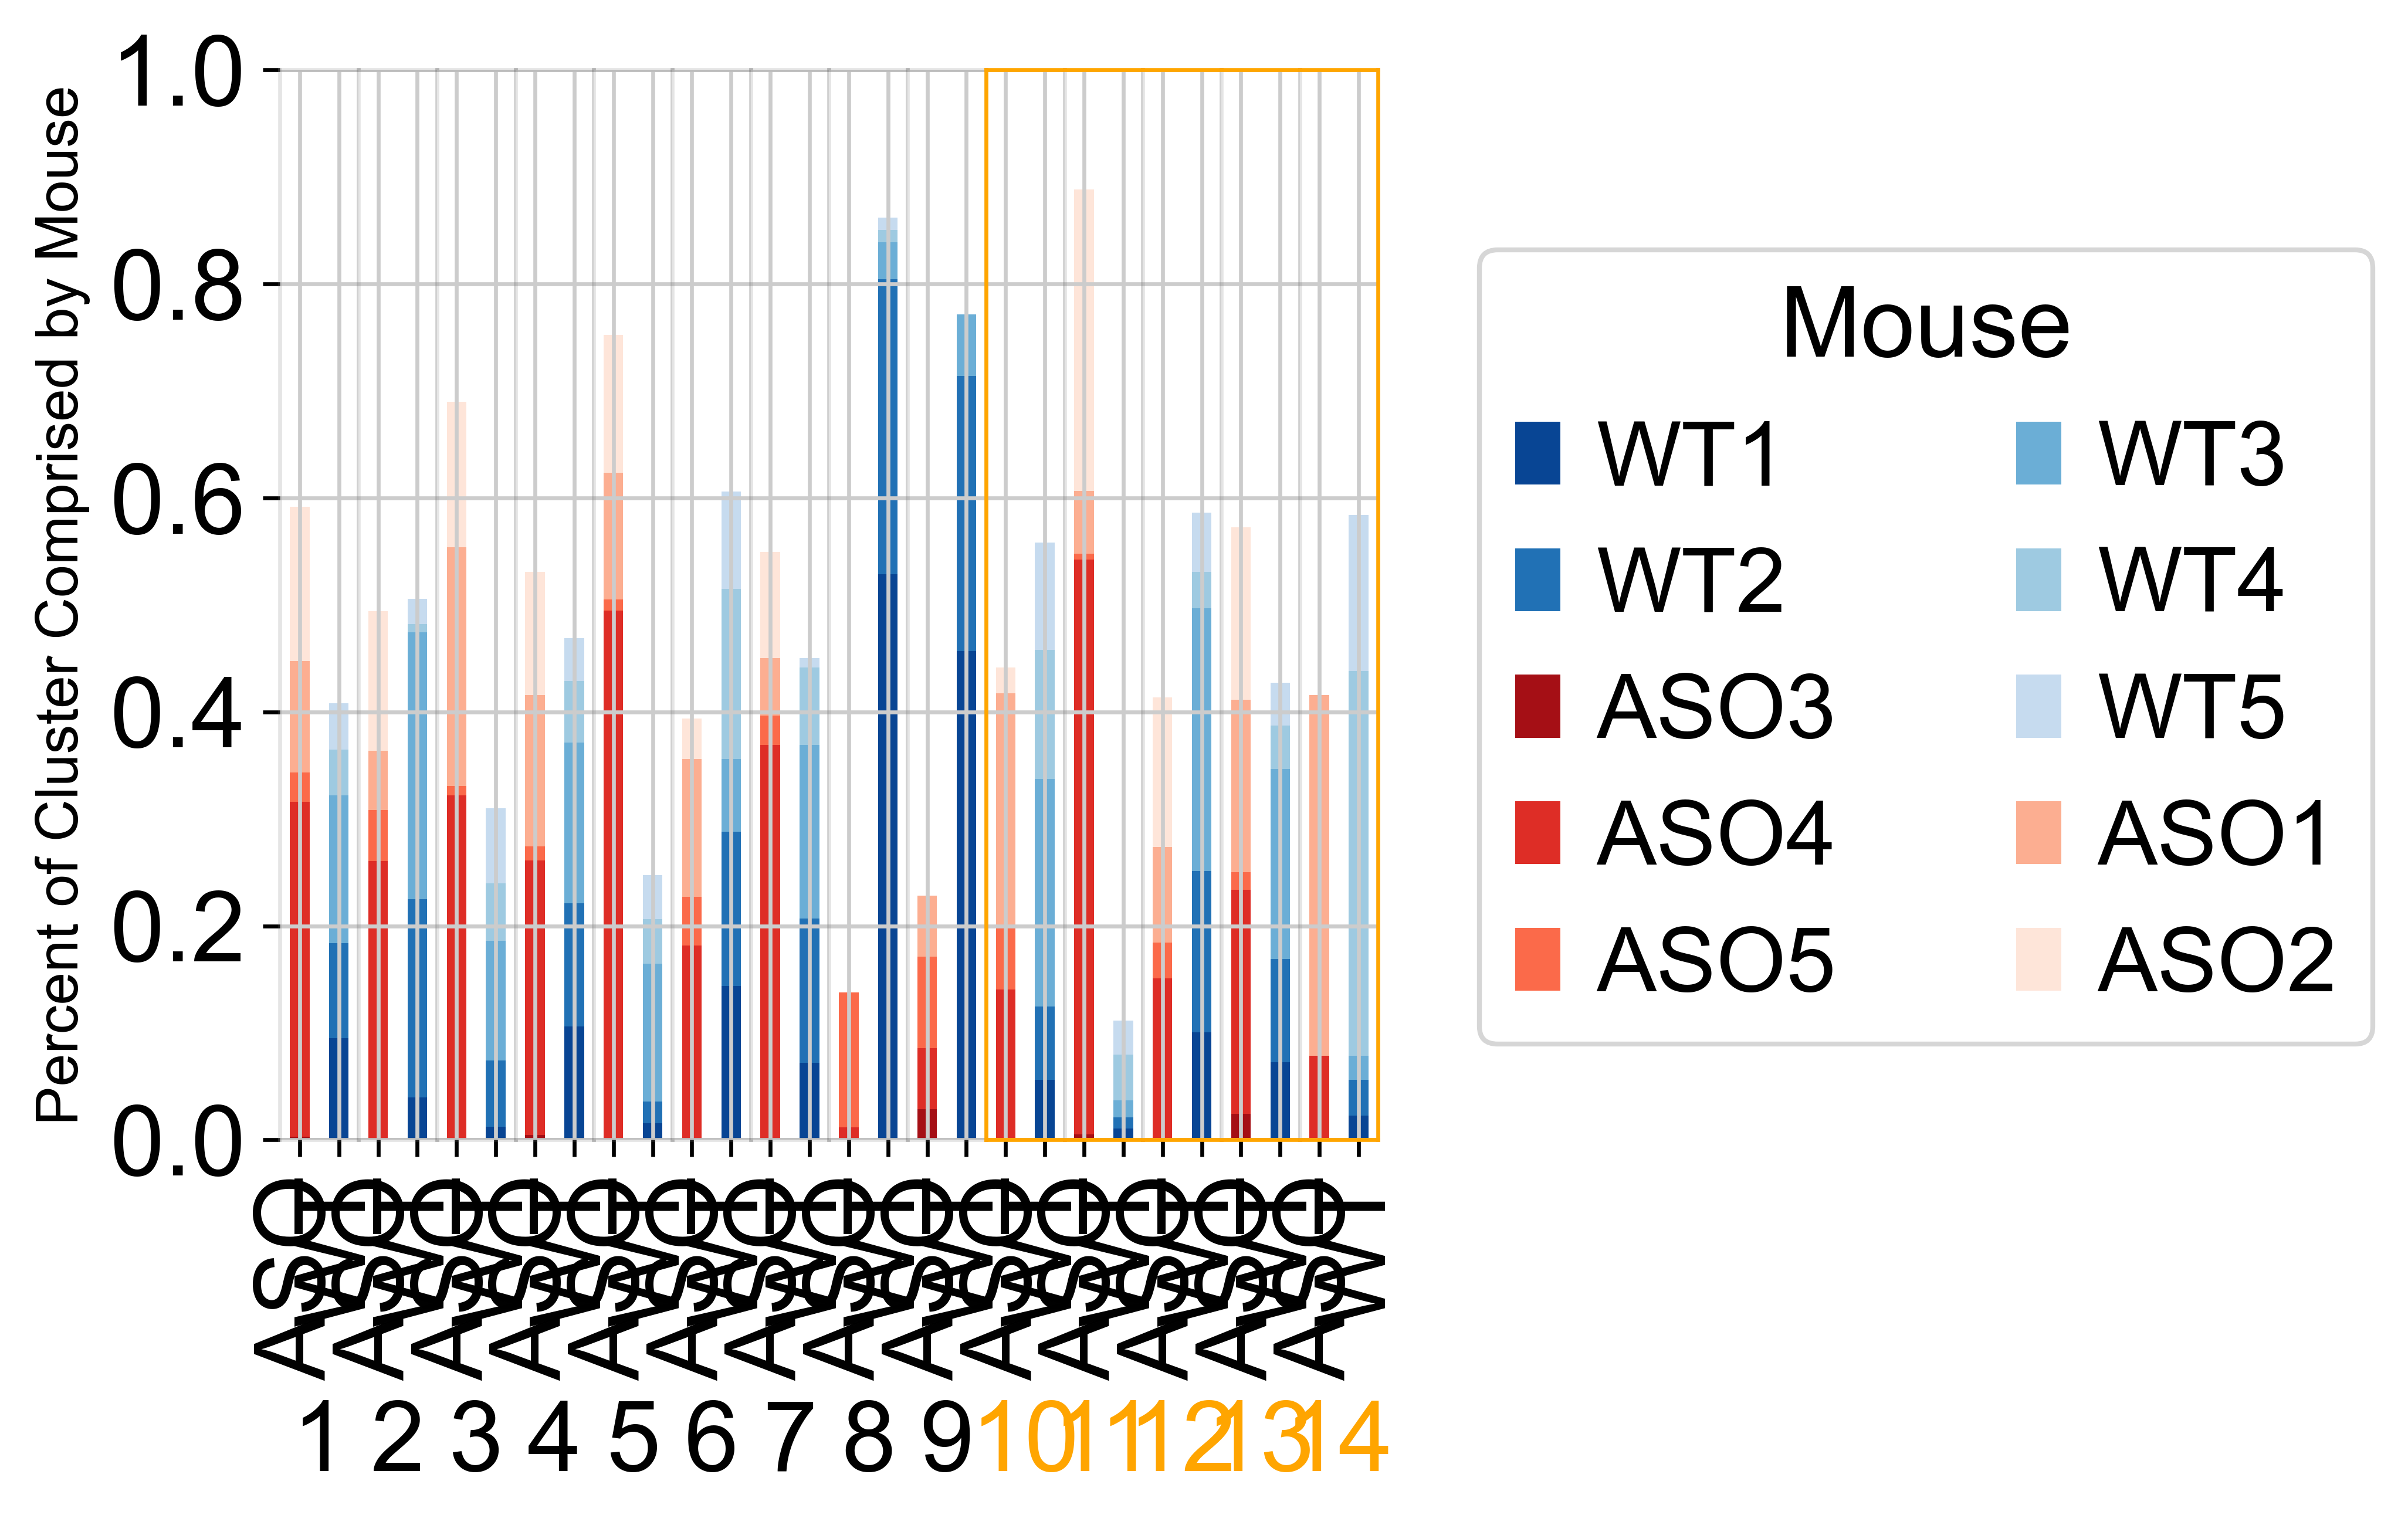

In [116]:
#color_dict = {2273.0:"#f8766d",2274:"#d89000",4788:"#a3a500",4789:"#39b600",4790:"#00bf7d",4798:"#00bfc4",4799:"#00b0f6",4800:"#9590ff",4801:"#e76bf3",4802:"#ff62bc"}

color_dict = {2273.0:Blues[8][0],
              2274:Blues[8][1],
              4788:Reds[5][0],
              4789:Reds[5][1],
              4790:Reds[5][2],
              4798:Blues[8][3],
              4799:Blues[8][4],
              4800:Blues[8][5],
              4790:Reds[5][2],
              4801:Reds[5][3],
              4802:Reds[5][4]}


#set up the plotting figure
fig = plt.figure(dpi = 300)
gs = fig.add_gridspec(1,len(count_df["seurat_clusters_renumbered"].unique()), wspace=0)
axs = gs.subplots(sharex=True, sharey=True)
color_alpha_marked = ('orange',1) #color/aplha of the highlighted boxes
color_alpha = ('grey',0.2) #color/alpha of all other boxes

#adding each plot to the figure
for i in count_df["seurat_clusters_renumbered"].unique():
    #set up the data frame to plot on this specific axis
    clust = i
    new_df = count_df.loc[count_df["seurat_clusters_renumbered"] == clust].drop(columns = ["seurat_clusters_renumbered"]).pivot(index = "Genotype", columns = "Mouse").reset_index()
    new_df.set_index('Genotype',inplace=True)
    new_df.replace(0, np.nan, inplace=True)

    plt_ind = int(i)-1
    new_df.plot.bar(stacked=True,ax = axs[plt_ind],color=list(color_dict.values())) #colormap='tab10'
    axs[plt_ind].get_legend().remove()
    # axs[plt_ind].get_legend().remove()
    axs[plt_ind].set_ylabel("Percent of Cluster Comprised by Mouse",size = 12)
    axs[plt_ind].set_xlabel(i)
    axs[plt_ind].tick_params(axis='x', labelrotation=90)
    axs[plt_ind].set_ylim(0,1)


#making all of the grey boxes
for ax in axs:
    ax.tick_params(left =False)
    for spine in ax.spines.values():
        spine.set_edgecolor(color_alpha)
    
axs[0].tick_params(left =True) #readd the ticks on the left


contam_groups = ['10','11','12','13','14'] 

# code for boxing each group individually
# for i in contam_groups:
#     plt_ind = int(i)-1
#     plt_indp1 = int(i)
#     axs[plt_ind].set_xlabel(i,color=color_alpha_marked)
#     axs[plt_ind].tick_params(labelcolor = color_alpha_marked)
#     for spine in axs[plt_ind].spines.values():
#          spine.set_edgecolor(color_alpha_marked)
#     axs[plt_indp1].spines['left'].set_color(color_alpha_marked)

#one making one big box around the contamination cluster
for i in contam_groups:
    plt_ind = int(i)-1
    plt_indp1 = int(i)
    axs[plt_ind].set_xlabel(i,color=color_alpha_marked)
    # axs[plt_ind].tick_params(labelcolor = color_alpha_marked)
    axs[plt_ind].spines['top'].set_color(color_alpha_marked)
    axs[plt_ind].spines['bottom'].set_color(color_alpha_marked)
    # for spine in axs[plt_ind].spines.values():
    #      spine.set_edgecolor(color_alpha_marked)

axs[13].spines['right'].set_color(color_alpha_marked)
axs[9].spines['left'].set_color(color_alpha_marked)

#add a legend
Mouse_dict = {2273.0: "WT1",2274.0: "WT2",4798.0: "WT3", 4799.0: "WT4", 4800.0: "WT5",
               4801.0: "ASO1", 4802.0: "ASO2", 4788.0 : "ASO3", 4789.0: "ASO4", 4790.0: "ASO5"
}

legend_list = [Mouse_dict[mid] for mid in count_df["Mouse"].unique().tolist()]
fig.legend(legend_list,loc='center left', bbox_to_anchor=(1, 0.5),ncol=2, title="Mouse")

fig.savefig('Figure_2_files/Staked_Bars.png',bbox_inches='tight')

Deprectiated: Plot of just the contamination clusters

In [17]:
contam_groups = ['3','7','8','10','12']
#set up the plotting figure
fig = plt.figure(dpi = 200)
gs = fig.add_gridspec(1,len(contam_groups), wspace=0)
axs = gs.subplots(sharex=True, sharey=True)

j = 0
for i in contam_groups:
    #set up the data frame to plot on this specific axis
    clust = i
    new_df = count_df.loc[count_df["Seurat_Clusters"] == clust].drop(columns = ["Seurat_Clusters"]).pivot(index = "Genotype", columns = "Mouse").reset_index()
    new_df.set_index('Genotype',inplace=True)
    new_df.replace(0, np.nan, inplace=True)

    plt_ind = int(i)
    new_df.plot.bar(stacked=True,ax = axs[j],color=list(color_dict.values()))
    axs[j].get_legend().remove()
    # axs[plt_ind].get_legend().remove()
    axs[j].set_ylabel("Percent of Cluster Comprised by Mouse",size = 12)
    axs[j].set_xlabel(i)
    axs[j].tick_params(axis='x', labelrotation=0)
    axs[j].set_ylim(0,1)

    j += 1
for ax in axs:
    ax.tick_params(left =False)
axs[0].tick_params(left =True) #readd the ticks on the left


fig.savefig('Figure_2_files/Staked_Bars_Contam_groups.png',bbox_inches='tight')

AttributeError: 'dict' object has no attribute 'figure'

## Remove contamination groups and add in sctype cell types to the file metadata

In [145]:
#remove contam groups
contam_groups = ['10','11','12','13','14'] #Old numbering: ['3','7','8','10','12']
data_filtered_no_contam = data_filtered[~data_filtered.obs.seurat_clusters_renumbered.isin(contam_groups)]

anno_df = pd.read_csv("Sc_type/sctype_classification.csv", index_col = 0,dtype="category")
data_filtered_no_contam.obs = data_filtered_no_contam.obs.join(anno_df)


#write the file
data_filtered_no_contam.write("Data_Files/" + "Filtered_NoContam_annotated_data_10082024.h5ad", compression="gzip")

# Setting up for Dirichlet-multinomial regression

Create a dataframe with each row being a mouse and each column being a different cell type with the last column the genotype of the mouse

This dataframe is used in R to run the Dirichlet-multinomial regression to investigate if the proportions of each cell type within each mouse are significantly differnet when grouped by genotype.

In [66]:
#read in data
df = data_filtered_no_contam.obs

#pull all the mouse IDs and create a list of them
mice = df["Mouse"].unique()
Mouse_list = [str(x) for x in mice]
#also create a list of their genotypes
geno_list = []
for mouse in mice:
    geno_list.append(df.loc[df['Mouse'] == mouse]["Genotype"].to_list()[0])

#loop over each mouse and compute the relevant percentages of each type of cell in each mouse
ser_list = []
counts_list = []
for i,mouse in enumerate(mice):
    ser = df.loc[df['Mouse'] ==mouse]["sctype_classification"].value_counts(normalize=True)
    ser.name = Mouse_list[i]
    ser["Genotype"] = geno_list[i]
    ser.index.name = ""
    ser_list.append(ser)

    #get # of cells for each mouse
    cell_num = len(df.loc[df['Mouse'] ==mouse].index.to_list())
    counts_list.append(cell_num)

df_concat = pd.concat(ser_list,axis=1).T
#add a column for Genotype that is 0 of WT or 1 for ASO
geno_int_list= []
for i in df_concat['Genotype'].to_list():
    if i == 'WT':
        geno_int_list.append(0)
    else:
        geno_int_list.append(1)
df_concat["Genotype_int"] = geno_int_list
df_concat["Number Of Cells"] = counts_list

#remove the mouse with three cells only
df_concat = df_concat.loc[df_concat.index != '4788.0']

df_concat
# df_concat = df_concat.drop(columns=["Genotype_int"])

#iqplot
colors = ['#f8766d','#00bfc4'] * 8
df_concat_melt = df_concat.drop(columns = ["Number Of Cells","Genotype_int"])
df_concat_melt = df_concat_melt.melt(id_vars = ["Genotype"],var_name='Cell_type',value_name='Proportion of Cells')
p = iqplot.strip(
    data=df_concat_melt,q = 'Proportion of Cells',cats = ["Cell_type","Genotype"],
    q_axis ='y',palette  = colors,title = 'Proportions of Cell Types', width = 600
)

bokeh.io.show(p)

#save the dataframe for R
df_concat = df_concat.drop(columns = ["Genotype","Number Of Cells"])
df_concat.to_csv('Cell_Percentages_20240810.csv')